# Double modelling notebook

With this notebook, we provide an example of how to model a double lensed quasar with a host galaxy and a lens galaxy component. The example is highly simplified and as we choose the same input model, a "perfect" reconstruction can be expected. Convergence in the PSO and MCMC chain is not guaranteed and this example provides a small run for illustration purpose.

We recommend to first go through the starting guide notebook, where the building blocks of *lenstronomy* are explained in detail.

In this notebook, we first create a mock image of a double lensed quasar and then apply a PSO and an MCMC chain to recover the input lens parameters.

*lenstronomy* comes with a set of neat features that facilitate the modelling of double lenses. This notebook introduces those features and how to use them.

In [1]:
# some python imports required
import matplotlib.pyplot as plt
import numpy as np
import corner
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# lenstronomy modules
from lenstronomy.Util import image_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param


## creating a mock image of a double
We follow closely the starting guide in how we create a mock image with noise properties. In this example we use an elliptical power-law convergence profile with external shear as the lens model, two different Sersic profiles as the light components of the deflector and the quasar host galaxy and a HST-like resolution of the image.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10


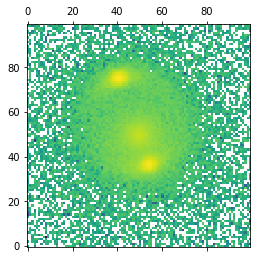

In [2]:
# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.2  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms, inverse=True)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR']
kwargs_shear = {'gamma1': 0.01, 'gamma2': 0.01}  # gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_spemd = {'theta_E': 1., 'gamma': 1.96, 'center_x': 0, 'center_y': 0, 'e1': 0.07, 'e2': -0.03}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400., 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0.1, 0.3
kwargs_sersic_ellipse = {'amp': 160, 'R_sersic': .5, 'n_sersic': 7, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': 0., 'e2': 0.1}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*100}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source,
                                         kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

## Setup of the modelling

*lenstronomy* comes with some neat features that facilitate the modeling of double lensed quasars. Among them are:

- one can couple different parameters together. E.g. the center of the source surface brightness of the host galaxy to the position of the quasar in the source plane. The keyword 'fix_to_point_source_list' can be set to 'True' for each individual index of the source surface brightness profile.

- The image positions of the quasar can be used as constraints on the lens model. Rather then having all lens model parameters as free parameters and solve for the image positions of the quasar, the image positions are treated as free parameters and part of the lens model parameters will be infered in post-processing by a non-linear solver. This option makes convergence in the lens model much faster. The option is set with the keyword 'solver'. There are two options available:
   - 'ELLIPSE': This solver inferes the ellipticitity of the first lens model by the best solution in mapping the two image positions to the same source plane position.
   - 'CENTER': This solver inferes the center of the first lens model by the best solution in mapping the two image positions to the same source plane position.



In [3]:
kwargs_model = {'lens_model_list': lens_model_list,
                               'source_light_model_list': source_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               'fixed_magnification_list': [False],
                             }
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                              'num_point_source_list': [2],
                              'solver_type': 'THETA_E_PHI',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                              }

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001
                             }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [4]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.1, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma1': 0., 'gamma2': 0.}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image+0.01, 'dec_image': y_image-0.01}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.1, 'e1': 0.2, 'e2': 0.2, 'gamma': .1, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma1': 0.1, 'gamma2': 0.1}]
kwargs_source_sigma = [{'R_sersic': 0.2, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.5, 'e1': 0, 'e2': 0, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 2, 'dec_image': [0.02] * 2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma1': -.2, 'gamma2': -0.2}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma1': 0.2, 'gamma2': 0.2}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}], kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

#kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps]
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 50, 'n_run': 50, 'walkerRatio': 10, 'sigma_scale': .1}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10
20


/Users/sibirrer/Software/lenstronomy/lenstronomy/LensModel/Profiles/epl.py:276: RuntimeWarning: invalid value encountered in power
  alpha = 2/(1+q)*(b/R)**t*R_omega


30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.992599132533897 reduced X^2 of best position
-4952.077072211612 logL
9978 effective number of data points
[{'theta_E': 0.9982019757524385, 'gamma': 1.9984779106764765, 'e1': 0.0852849099181172, 'e2': -0.011293914562183847, 'center_x': 0.007714010423781708, 'center_y': -0.00039491623451750414}, {'gamma1': 0.015938808152764824, 'gamma2': 0.021278535939428266, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.3188687472742672, 'n_sersic': 4.99998293938288, 'e1': -0.0001078461264951165, 'e2': 0.0751759363530652, 'center_x': 0.10669421546236169, 'center_y': 0.3106746647335559}] source result
[{'amp': 1, 'R_sersic': 1.10126406277061, 'n_sersic': 2.110052675164482, 'center_x': -0.000861616121850678, 'center_y': -0.004599066362142707}] lens light result
[{'ra_image': array([ 0.44807599, -0.22308655]), 'dec_image': array([ 1.27434898, -0.6551874 ]), 'point_amp': array([1., 1.])}] poi

  0%|          | 0/100 [00:00<?, ?it/s]/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [05:35<00:00,  3.79s/it]

Computing the MCMC...
Number of walkers =  180
Burn-in iterations:  50
Sampling iterations (in current run): 100
338.6400692462921 time taken for MCMC sampling


-0.9905388027370856 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9905388027370856


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]


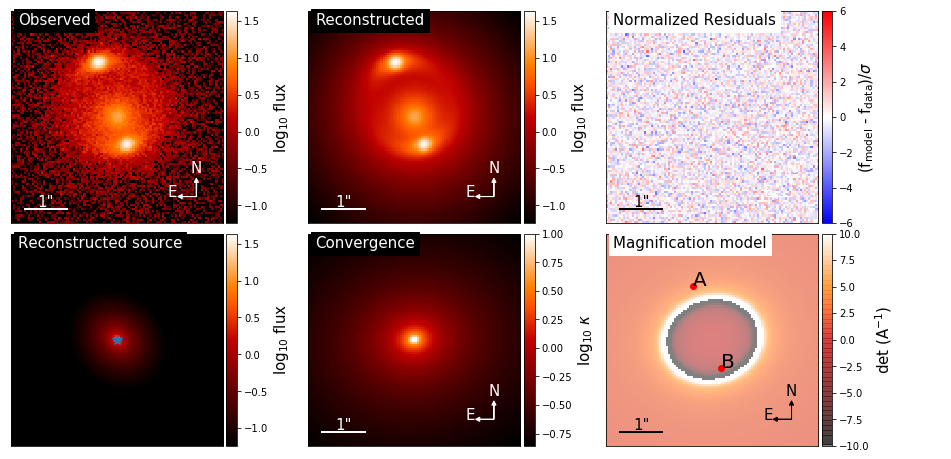

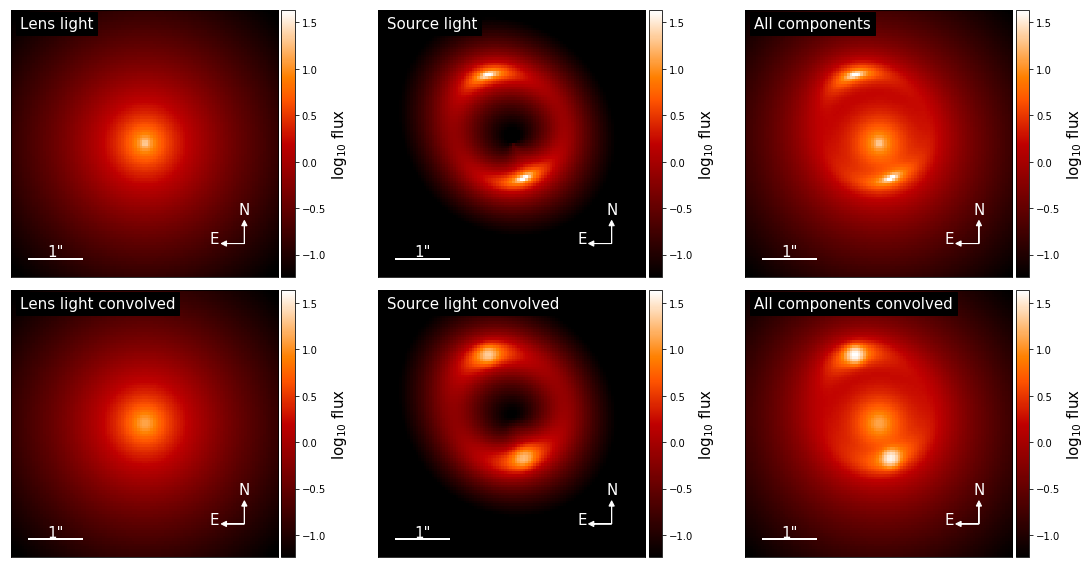

{'kwargs_lens': [{'theta_E': 1.0003148734060052, 'gamma': 1.997819792911272, 'e1': 0.0826055687206674, 'e2': -0.02487572949820631, 'center_x': 0.007141902275517252, 'center_y': 0.0009049799633646079}, {'gamma1': 0.014813790574134537, 'gamma2': 0.012873948203333064, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 351.9259430946628, 'R_sersic': 0.32836591627639883, 'n_sersic': 4.966791214586749, 'e1': -0.003092699661817799, 'e2': 0.0828901544492445, 'center_x': 0.10836607790817274, 'center_y': 0.3118086144734332}], 'kwargs_lens_light': [{'amp': 351.59118208961104, 'R_sersic': 1.1030179325967806, 'n_sersic': 2.1214741884612685, 'center_x': -0.002479632572645737, 'center_y': -0.003574422019380771}], 'kwargs_ps': [{'ra_image': array([ 0.44780252, -0.22212146]), 'dec_image': array([ 1.27457918, -0.65484383]), 'point_amp': array([397.0058092 , 357.24120052])}], 'kwargs_special': {}, 'kwargs_extinction': []}


In [5]:
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  18
parameters in order:  ['gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  9000


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


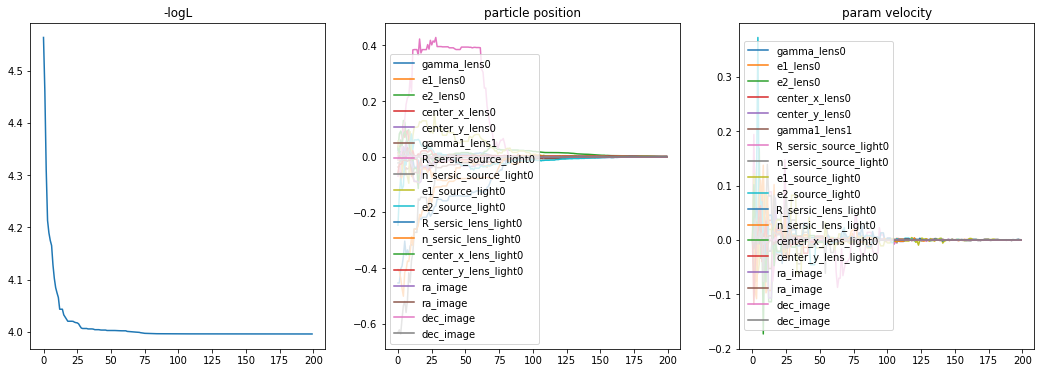

<Figure size 432x288 with 0 Axes>

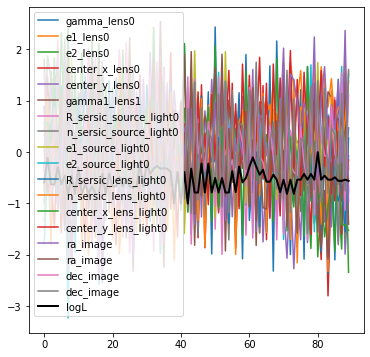

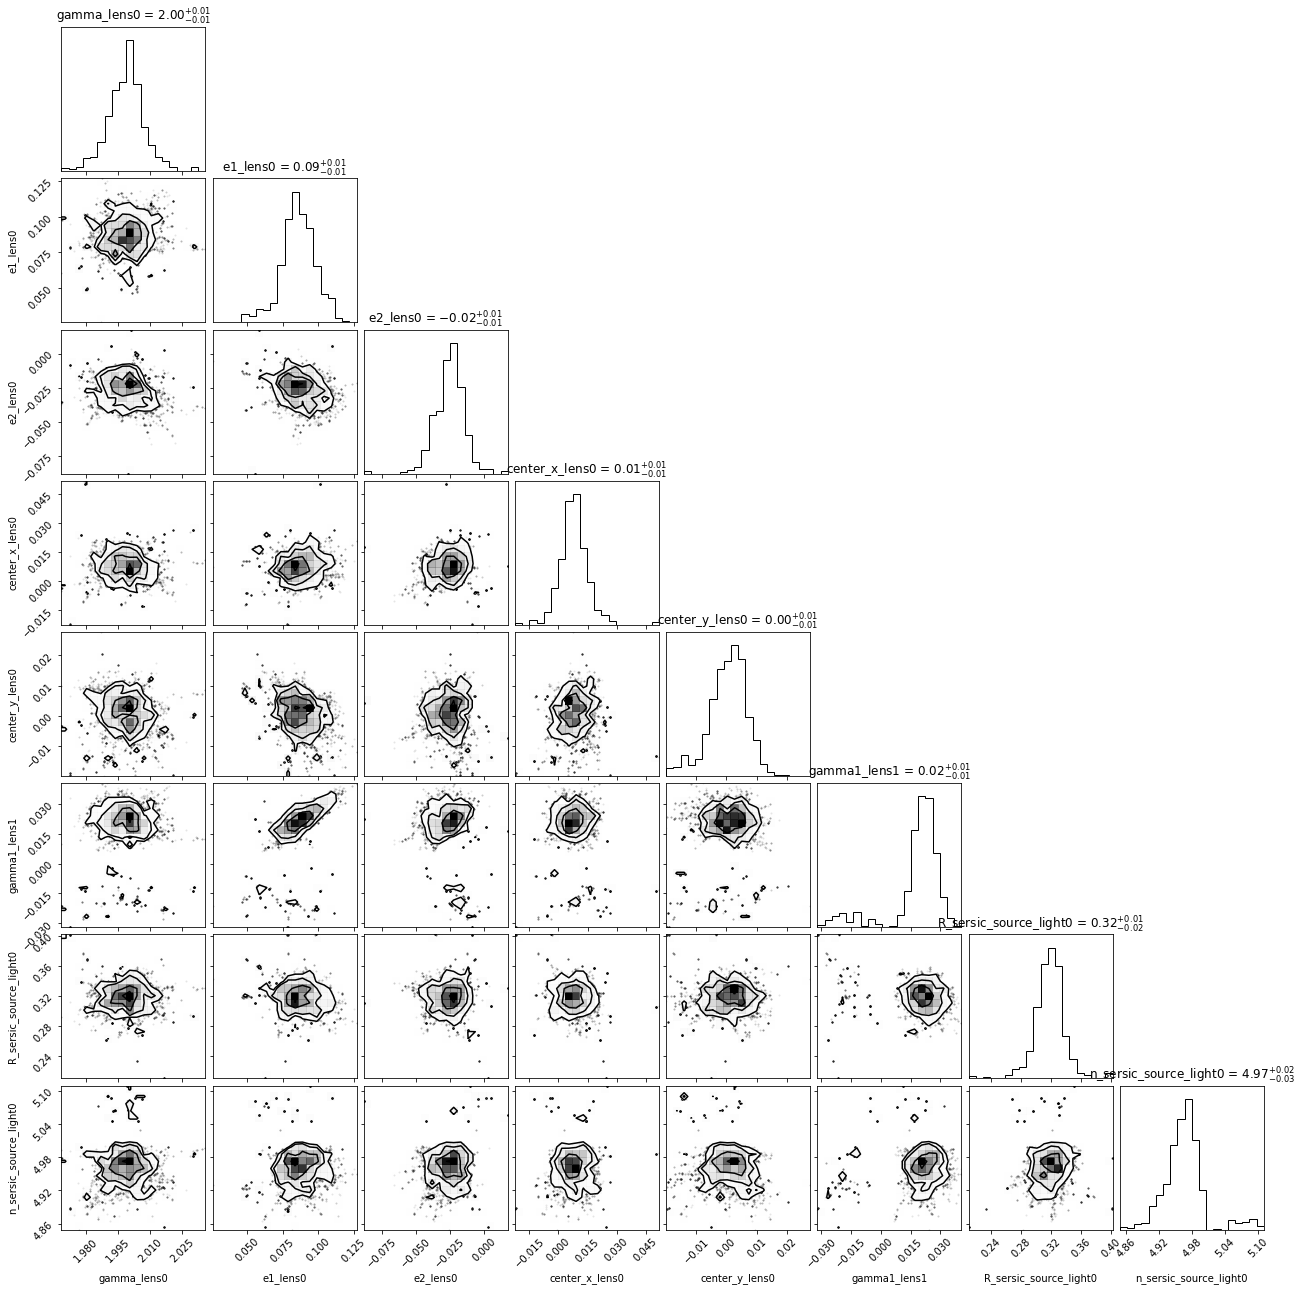

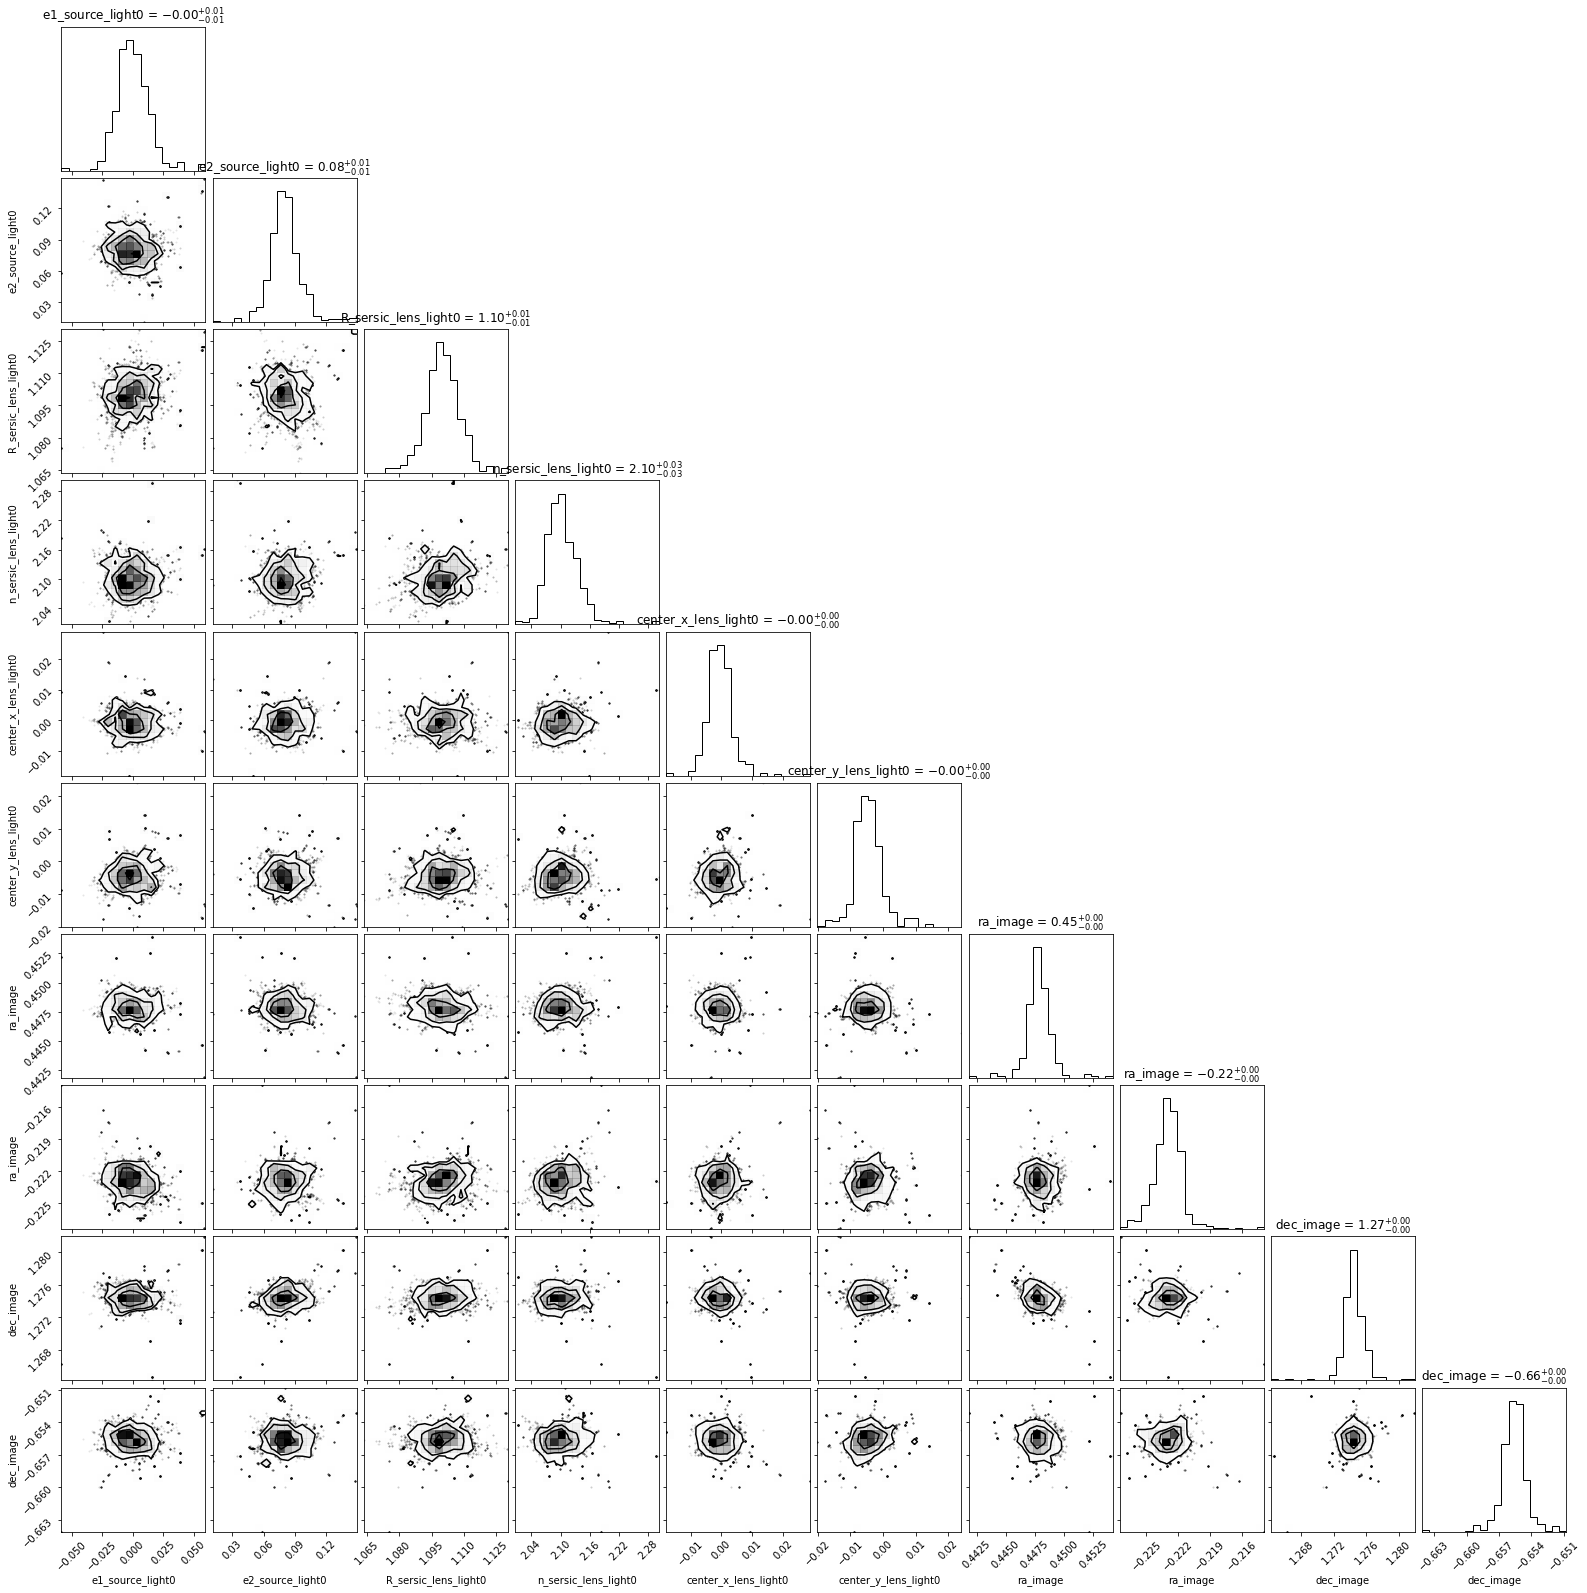

In [6]:
from lenstronomy.Plots import chain_plot

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
        plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)